In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = '.'
DATA_DIR = f'{DIR}/data'
NAME = 'cifar10'

training_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, 
                                            transform=transforms.ToTensor())

training_indices, validation_indices, _, _ = train_test_split(
    range(len(training_set)),
    training_set.targets,
    stratify=training_set.targets,
    test_size=0.1,
)
training_split = torch.utils.data.Subset(training_set, training_indices)
validation_split = torch.utils.data.Subset(training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
45000 in training set
5000 in validation set


/usr/local/anaconda3/envs/cs7643-final-project-cpu/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459065530/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0][0/8]	Loss 2.3979 (2.3979)	Prec @1 0.1250 (0.1250)	
Epoch 0 | Training accuracy: 0.19599999487400055% | Validation accuracy: 0.25619998574256897%


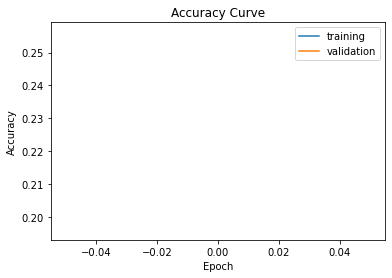

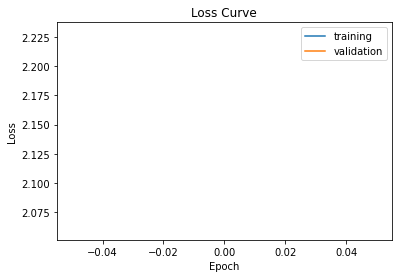

Best Validation Acccuracy: 0.2562


In [4]:
import team36
from team36.mnist.vgg import VGG
from team36.training import train, validate

learning_rate = 1e-3
momentum = 5e-1
weight_decay = 5e-2
batch_size = 128
epochs = 1

sampler = torch.utils.data.RandomSampler(training_split, replacement=True, num_samples=1000)
training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, sampler=sampler)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False, num_workers=2)

model = VGG(image_size=32, in_channels=3)
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
validation_accuracy_history = []
validation_loss_history = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion)
    validation_accuracy_history.append(acc)
    validation_loss_history.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(validation_accuracy_history, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(validation_loss_history, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))